# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [70]:
# Load the libraries as required.
import numpy as np
import os
import pandas as pd
import pickle
import shap

import matplotlib.pyplot as plt

from scipy.stats import shapiro

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

In [71]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [72]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [73]:
X = fires_dt.drop(columns='area')
Y = fires_dt['area']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [74]:
num_columns = X.select_dtypes(include=['number']).columns.to_list()

cat_columns = X.select_dtypes(exclude=['number']).columns.to_list()

print(num_columns)

print(cat_columns)

for col in num_columns:
    stat, p = shapiro(X_train[col])
    print("Shapiro-Wilk Test: p-value =", p)

# To determine normal distribution and help in selecting the imputer
# Going for knn, median imputer might work as but making the assumption that weather patterns are in general similar to days close to it.

['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
['month', 'day']
Shapiro-Wilk Test: p-value = 1.4313616264471918e-11
Shapiro-Wilk Test: p-value = 7.341874910761145e-15
Shapiro-Wilk Test: p-value = 1.8953224224805251e-31
Shapiro-Wilk Test: p-value = 5.1427027081274446e-09
Shapiro-Wilk Test: p-value = 4.945356645491529e-21
Shapiro-Wilk Test: p-value = 2.9809112334078236e-07
Shapiro-Wilk Test: p-value = 0.005180808715522289
Shapiro-Wilk Test: p-value = 1.4051897145872516e-10
Shapiro-Wilk Test: p-value = 1.5389520058306516e-07
Shapiro-Wilk Test: p-value = 6.419950823411647e-40


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [75]:
num_transfomer_1 = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('standardizer', RobustScaler())
])

cat_transfomer_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preproc1 = ColumnTransformer([
    ('num_transforms_1', num_transfomer_1, num_columns),
    ('cat_transforms_2', cat_transfomer_1, cat_columns)
])

preproc1

ColumnTransformer(transformers=[('num_transforms_1',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('standardizer',
                                                  RobustScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms_2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [76]:
coordinate_columns = ['coord_x', 'coord_y']
fwi_columns = ['ffmc', 'dmc', 'dc', 'isi']
weather_columns = ['temp', 'rh', 'wind', 'rain']

coordinate_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('standardizer', RobustScaler())
])

# PowerTransformer - to help with skewed data
fwi_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('standardizer', RobustScaler()),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

# PolynomialFeatures to see if there are interactions within weather features
weather_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('standardizer', RobustScaler()),
    ('transform', PolynomialFeatures(degree=2, interaction_only=True))
])

cat_transfomer_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preproc2 = ColumnTransformer([
    ('coordinate_transforms', coordinate_transformer, coordinate_columns),
    ('fwi_transforms', fwi_transformer, fwi_columns),
    ('weather_transforms', weather_transformer, weather_columns),
    ('cat_transforms_2', cat_transfomer_2, cat_columns)
])

preproc2

ColumnTransformer(transformers=[('coordinate_transforms',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('standardizer',
                                                  RobustScaler())]),
                                 ['coord_x', 'coord_y']),
                                ('fwi_transforms',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('standardizer',
                                                  RobustScaler()),
                                                 ('transform',
                                                  PowerTransformer())]),
                                 ['ffmc', 'dmc', 'dc', 'isi']),
                                ('weather_transforms',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(weights='distance')),
                                                 ('standardizer',
                                                  RobustScaler()),
                                                 ('transform',
                                                  PolynomialFeatures(interaction_only=True))]),
                                 ['temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms_2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [77]:
# Pipeline A = preproc1 + baseline

pipeline_a = Pipeline([
    ('preproc1', preproc1),
    ('baseline_model', DecisionTreeRegressor(random_state=42))
])

pipeline_a

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('num_transforms_1',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('baseline_model', DecisionTreeRegressor(random_state=42))])

In [78]:
# Pipeline B = preproc2 + baseline

pipeline_b = Pipeline([
    ('preproc2', preproc2),
    ('baseline_model', DecisionTreeRegressor(random_state=42))
])

pipeline_b

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('coordinate_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y']),
                                                 ('fwi_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffm...
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('baseline_model', DecisionTreeRegressor(random_state=42))])

In [79]:
# Pipeline C = preproc1 + advanced model

pipeline_c = Pipeline([
    ('preproc1', preproc1),
    ('advanced_model', RandomForestRegressor(random_state=42))
])

pipeline_c

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('num_transforms_1',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('advanced_model', RandomForestRegressor(random_state=42))])

In [80]:
# Pipeline D = preproc2 + advanced model

pipeline_d = Pipeline([
    ('preproc2', preproc2),
    ('advanced_model', RandomForestRegressor(random_state=42))
])

pipeline_d
    

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('coordinate_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y']),
                                                 ('fwi_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffm...
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('advanced_model', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [81]:
scoring = ['neg_mean_absolute_error','neg_mean_squared_error','r2','explained_variance']

param_grid_baseline = {
    'baseline_model__max_depth': [None, 5, 10, 15],
    'baseline_model__min_samples_split': [2, 5, 10]
}

param_grid_advanced = {
    'advanced_model__n_estimators': [50, 100, 200], 
    'advanced_model__max_depth': [None, 10, 20], 
    'advanced_model__min_samples_split': [2, 5]
}

In [82]:
grid_cv_a = GridSearchCV(
    estimator=pipeline_a,
    param_grid=param_grid_baseline,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error'
)

grid_cv_a.fit(X_train, Y_train)

res_a = grid_cv_a.cv_results_
res_a = pd.DataFrame(res_a)

res_a.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_baseline_model__max_depth',
       'param_baseline_model__min_samples_split', 'params',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'split3_test_neg_mean_squared_error',
       'split4_test_neg_mean_squared_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2',
       '

In [83]:
grid_cv_a.best_params_

{'baseline_model__max_depth': 5, 'baseline_model__min_samples_split': 10}

In [84]:
grid_cv_a.best_estimator_

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('num_transforms_1',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('baseline_model',
                 DecisionTreeRegressor(max_depth=5, min_samples_split=10,
                                       random_state=42))])

In [85]:
grid_cv_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_baseline,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error'
)

grid_cv_b.fit(X_train, Y_train)

res_b = grid_cv_b.cv_results_
res_b = pd.DataFrame(res_b)

res_b.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_baseline_model__max_depth',
       'param_baseline_model__min_samples_split', 'params',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'split3_test_neg_mean_squared_error',
       'split4_test_neg_mean_squared_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2',
       '

In [86]:
grid_cv_b.best_params_

{'baseline_model__max_depth': 5, 'baseline_model__min_samples_split': 10}

In [87]:
grid_cv_b.best_estimator_

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('coordinate_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y']),
                                                 ('fwi_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffm...
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('baseline_model',
                 DecisionTreeRegressor(max_depth=5, min_samples_split=10,
                                       random_state=42))])

In [88]:
grid_cv_c = GridSearchCV(
    estimator=pipeline_c,
    param_grid=param_grid_advanced,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error'
)

grid_cv_c.fit(X_train, Y_train)

res_c = grid_cv_c.cv_results_
res_c = pd.DataFrame(res_c)

res_c.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_advanced_model__max_depth',
       'param_advanced_model__min_samples_split',
       'param_advanced_model__n_estimators', 'params',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'split3_test_neg_mean_squared_error',
       'split4_test_neg_mean_squared_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2

In [89]:
grid_cv_c.best_params_

{'advanced_model__max_depth': 20,
 'advanced_model__min_samples_split': 5,
 'advanced_model__n_estimators': 200}

In [90]:
grid_cv_c.best_estimator_

Pipeline(steps=[('preproc1',
                 ColumnTransformer(transformers=[('num_transforms_1',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('advanced_model',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

In [91]:
grid_cv_d = GridSearchCV(
    estimator=pipeline_d,
    param_grid=param_grid_advanced,
    scoring=scoring,
    cv=5,
    refit='neg_mean_squared_error'
)

grid_cv_d.fit(X_train, Y_train)

res_d = grid_cv_d.cv_results_
res_d = pd.DataFrame(res_d)

res_d.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_advanced_model__max_depth',
       'param_advanced_model__min_samples_split',
       'param_advanced_model__n_estimators', 'params',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'split3_test_neg_mean_squared_error',
       'split4_test_neg_mean_squared_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2

In [92]:
grid_cv_d.best_params_

{'advanced_model__max_depth': None,
 'advanced_model__min_samples_split': 5,
 'advanced_model__n_estimators': 100}

In [93]:
grid_cv_d.best_estimator_

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('coordinate_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y']),
                                                 ('fwi_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffm...
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('advanced_model',
                 RandomForestRegressor(min_samples_split=5, random_state=42))])

In [94]:
best_rmse_rf_a = (-grid_cv_a.best_score_) ** 0.5
best_rmse_rf_b = (-grid_cv_b.best_score_) ** 0.5
best_rmse_rf_c = (-grid_cv_c.best_score_) ** 0.5
best_rmse_rf_d = (-grid_cv_d.best_score_) ** 0.5

print(best_rmse_rf_a)
print(best_rmse_rf_b)
print(best_rmse_rf_c)
print(best_rmse_rf_d)

74.96608429813811
76.45797987419152
56.20624598222422
55.58802234448396


# Evaluate

+ Which model has the best performance?

Based on the best RMSE from GridSearchCV, pipeline_d has the best performance since it has the lowest value.

# Export

+ Save the best performing model to a pickle file.

In [95]:
pickle_dir = '../../05_src/data/fires/'
os.makedirs(pickle_dir, exist_ok=True)

best_estimator = grid_cv_d.best_estimator_

best_estimator.fit(X_train, Y_train)

outpath = os.path.join(pickle_dir, 'assignment_2.pkl')

with open(outpath, 'wb') as f:
        pickle.dump(best_estimator, f)

# You can optionally print a confirmation
print(f"Model saved to {outpath}")

Model saved to ../../05_src/data/fires/assignment_2.pkl


+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction?
        - I can't make sense of the observations when looking at them individually, plotting them seems to show me that the dmc doesn't specifically impact the values, with higher temp and lower rh having more impact to the area.

    - In general, across the complete training set, which features are the most and least important.
        - Across the complete set, it seems like the features that are most important are dmc, combination of temp and rh, coord_x, coord_y, and sat(day)
        - Least important are may (month), tue, wed, thu, fri (day), and wind (if taken alone)

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?
    - I would not remove any of them yet, I would probably try running different models first and running shap on the other pipelines and implement other preprocessors. I cannot draw any conclusions on my current experiment.
    - Hypothetically, I would probably start again with the FWI and weather features, see how they impact area combined and maybe as individual features, FWI just because these are the numbers probably gathered by domain experts, and weather cause it just makes sense to me. This would probably induce human bias. I would also try automated methods, simply just iterating and running the models multiple times having the program run through different combinations, and try to determine the output based on that. I believe this would be similar to the credit experiment.
    - For testing, I think GridSearch is already a good way to determine the models performance, I'll run that for every model I experiment with.

In [96]:
model_pkl_file = os.path.join(
    pickle_dir, 
    "assignment_2.pkl"
)

with open(model_pkl_file, 'rb') as file:
    pipe_import = pickle.load(file)

pipe_import

Pipeline(steps=[('preproc2',
                 ColumnTransformer(transformers=[('coordinate_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler())]),
                                                  ['coord_x', 'coord_y']),
                                                 ('fwi_transforms',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffm...
                                                                  ('standardizer',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  ['temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat_transforms_2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('advanced_model',
                 RandomForestRegressor(min_samples_split=5, random_state=42))])

Number of features in the data: 36
Number of feature names: 36


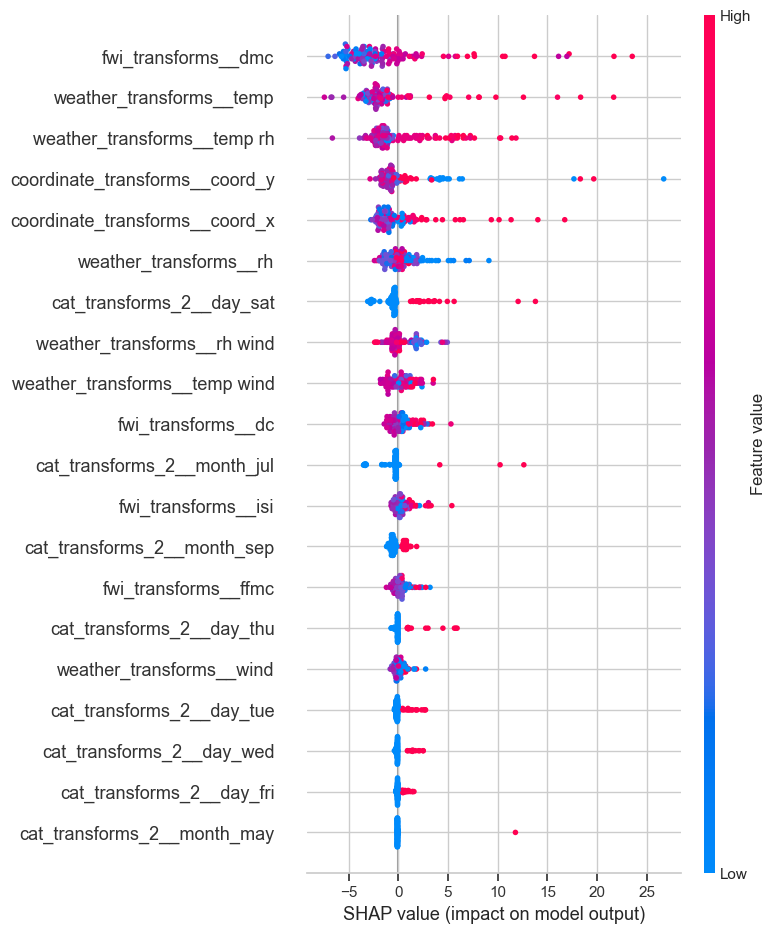

In [97]:
data_transform = pipe_import.named_steps['preproc2'].transform(X_test)
feature_names_preproc = pipe_import.named_steps['preproc2'].get_feature_names_out()

num_features = data_transform.shape[1]
num_feature_names = len(feature_names_preproc)

print(f"Number of features in the data: {num_features}")
print(f"Number of feature names: {num_feature_names}")

explainer = shap.TreeExplainer(pipe_import.named_steps['advanced_model'])

shap_values = explainer.shap_values(data_transform)

shap.summary_plot(shap_values, data_transform, feature_names = feature_names_preproc)

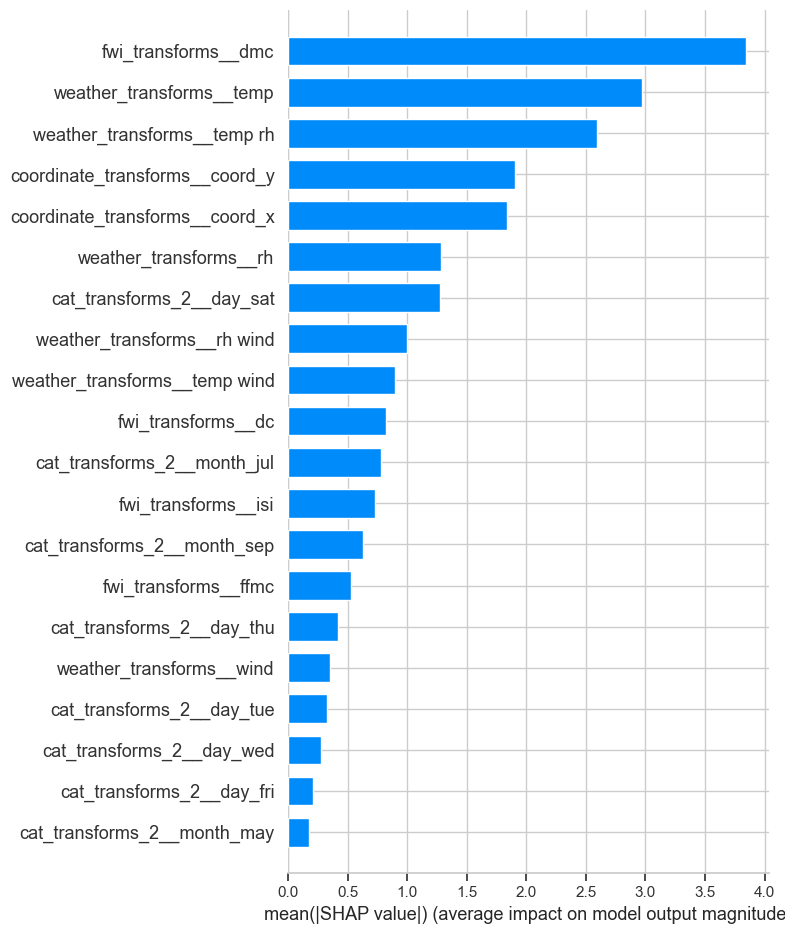

In [98]:
shap.summary_plot(shap_values, data_transform, feature_names = feature_names_preproc, plot_type='bar')

In [99]:
combined = pd.concat([X_test.reset_index(drop=True), Y_test.reset_index(drop=True)], axis=1)

sorted_combined = combined.sort_values(by=['area', 'dmc'], ascending=[False, False])

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(sorted_combined)

display(sorted_combined)

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
51,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
71,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
81,1,5,sep,sun,93.5,149.3,728.6,8.1,27.8,27,3.1,0.0,95.18
47,6,3,apr,sun,91.0,14.6,25.6,12.3,13.7,33,9.4,0.0,61.13
68,8,6,aug,sat,92.2,81.8,480.8,11.9,20.1,34,4.5,0.0,58.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3,4,mar,wed,93.4,17.3,28.3,9.9,8.9,35,8.0,0.0,0.00
112,2,4,mar,tue,93.4,15.0,25.6,11.4,15.2,19,7.6,0.0,0.00
26,9,9,feb,fri,86.6,13.2,43.0,5.3,15.7,43,3.1,0.0,0.00
119,9,9,feb,thu,84.2,6.8,26.6,7.7,6.7,79,3.1,0.0,0.00


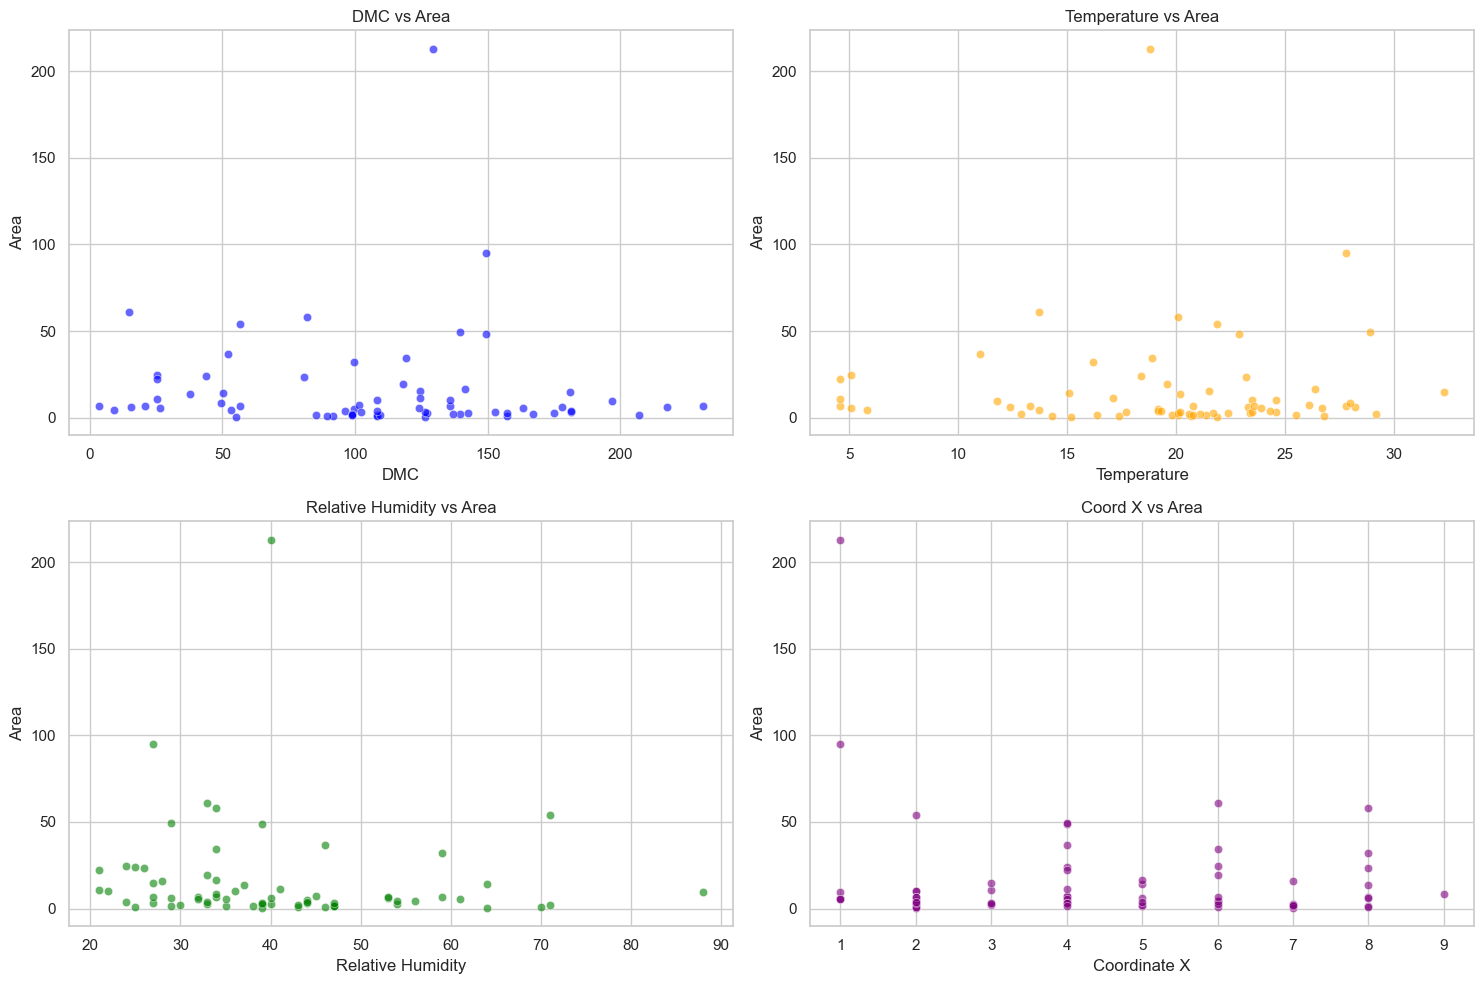

In [100]:
combined = combined[(combined['area'] != 0) & (combined['area'] < 1000)]

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(ax=axes[0, 0], x='dmc', y='area', data=combined, color='blue', alpha=0.6)
axes[0, 0].set_title('DMC vs Area')
axes[0, 0].set_xlabel('DMC')
axes[0, 0].set_ylabel('Area')

sns.scatterplot(ax=axes[0, 1], x='temp', y='area', data=combined, color='orange', alpha=0.6)
axes[0, 1].set_title('Temperature vs Area')
axes[0, 1].set_xlabel('Temperature')
axes[0, 1].set_ylabel('Area')

sns.scatterplot(ax=axes[1, 0], x='rh', y='area', data=combined, color='green', alpha=0.6)
axes[1, 0].set_title('Relative Humidity vs Area')
axes[1, 0].set_xlabel('Relative Humidity')
axes[1, 0].set_ylabel('Area')

sns.scatterplot(ax=axes[1, 1], x='coord_x', y='area', data=combined, color='purple', alpha=0.6)
axes[1, 1].set_title('Coord X vs Area')
axes[1, 1].set_xlabel('Coordinate X')
axes[1, 1].set_ylabel('Area')

plt.tight_layout()
plt.show()

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [x] Created a branch with the correct naming convention.
- [x] Ensured that the repository is public.
- [x] Reviewed the PR description guidelines and adhered to them.
- [x] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.